In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from pandas import DataFrame,Series
import seaborn as sns
from tqdm.auto import tqdm
import umap
import json

from src.parsing import read_post_data

sns.set_theme(style="whitegrid")

In [3]:
data = read_post_data('./data/posts.csv')
data = data[data.tags.map(len) > 0]

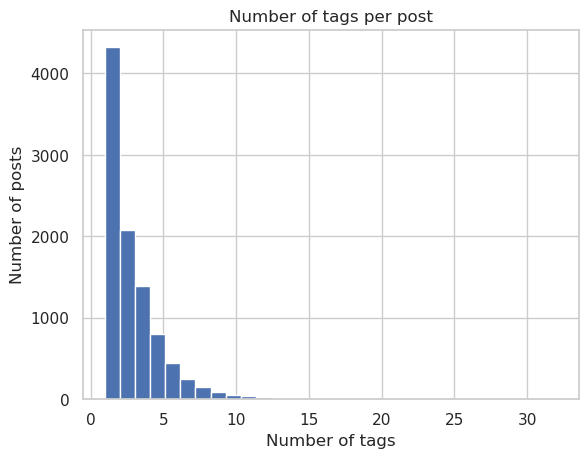

In [10]:
n_tags_per_doc = data.tags.map(len)
n_tags_per_doc.hist(bins=30);
plt.title('Number of tags per post'); plt.xlabel('Number of tags'); plt.ylabel('Number of posts');

In [21]:
from collections import defaultdict
from typing import List
from pandas import DataFrame


def estimate_cooccurance_probabilities(tags: List[List[str]], symmetric:bool=False, normalize:bool=True) -> DataFrame:
    all_tags = sorted(np.unique(np.concatenate(tags)))
    cooccurance = defaultdict(lambda: defaultdict(int))
    for tag_list in tags:
        for t1 in tag_list:
            for t2 in tag_list:
                cooccurance[t1][t2] += 1
    cooccurance = DataFrame(cooccurance).loc[all_tags, all_tags].fillna(0).astype(int)
    if not symmetric and normalize:
        cooccurance /= cooccurance.sum(axis=1).values.reshape(-1, 1)
        return cooccurance
    
    cooccurance = (cooccurance + cooccurance.T) // 2
    if normalize:
        diag_vals = np.diag(cooccurance.values)
        diag_vals = np.repeat(diag_vals, len(diag_vals)).reshape(len(diag_vals), len(diag_vals))
        diag_vals = np.maximum(diag_vals, diag_vals.T)
        cooccurance /= diag_vals

    return cooccurance


def extract_clustering_from_sns(cmap):
    linkage = cmap.dendrogram_row.linkage
    leaves = cmap.dendrogram_row.reordered_ind
    return linkage, leaves

### All tags

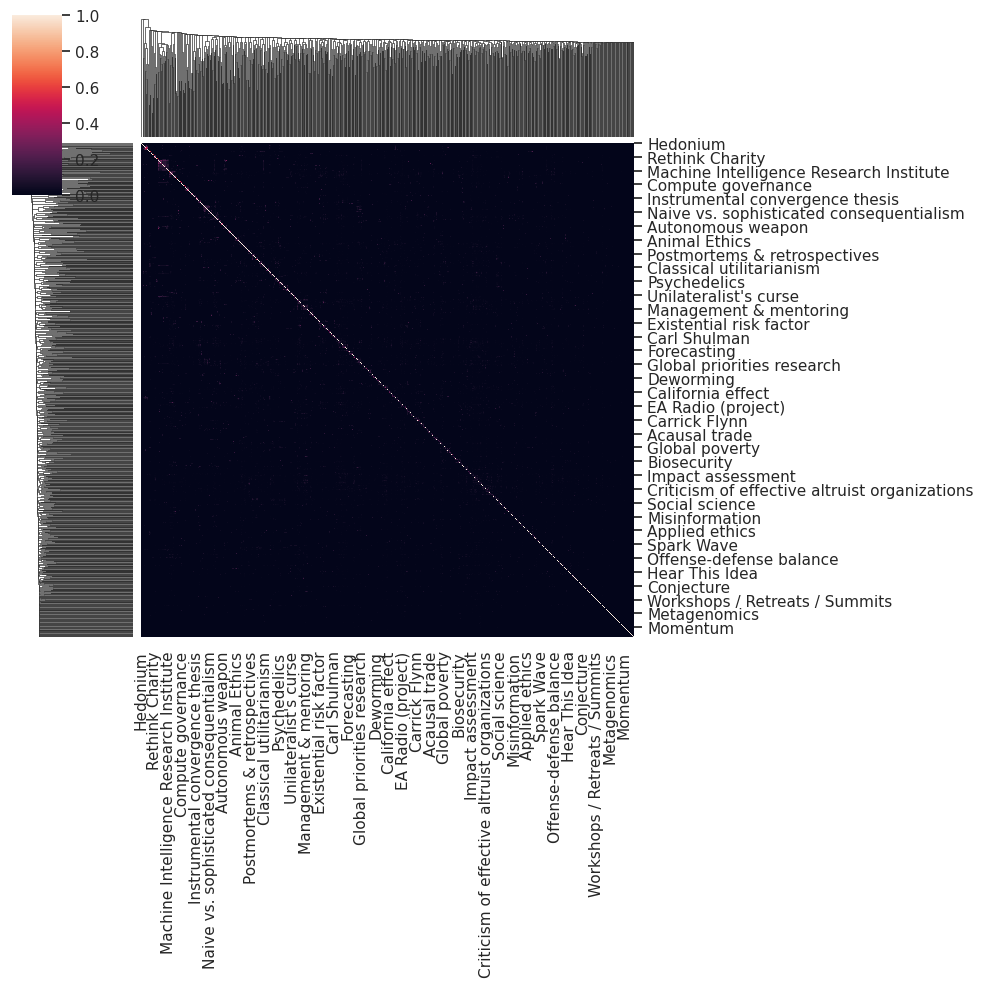

In [6]:
tag_coocs = estimate_cooccurance_probabilities(data.tags, symmetric=True, normalize=True)
sns.clustermap(tag_coocs);

### Filter tags

In [77]:
data_filt = data[(n_tags_per_doc > 5) & (n_tags_per_doc < 15)]
data_filt.shape

(1065, 14)

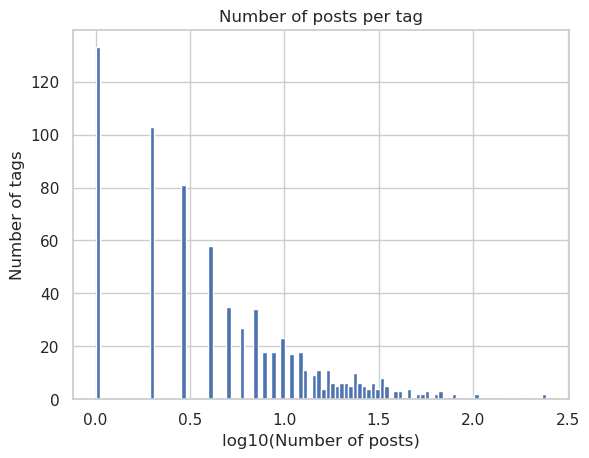

In [78]:
n_docs_per_tag = pd.value_counts(np.concatenate(data_filt.tags.values))
np.log10(n_docs_per_tag).hist(bins=100);
plt.title('Number of posts per tag'); plt.xlabel('log10(Number of posts)'); plt.ylabel('Number of tags');

In [88]:
all_tags_filt = n_docs_per_tag.index[(n_docs_per_tag > 15)]
tags_filt = data_filt.tags.map(np.array).map(lambda x: x[np.in1d(x, all_tags_filt)])
tags_filt = tags_filt[tags_filt.map(len) > 0]

all_tags_filt.size, tags_filt.size

(129, 1062)

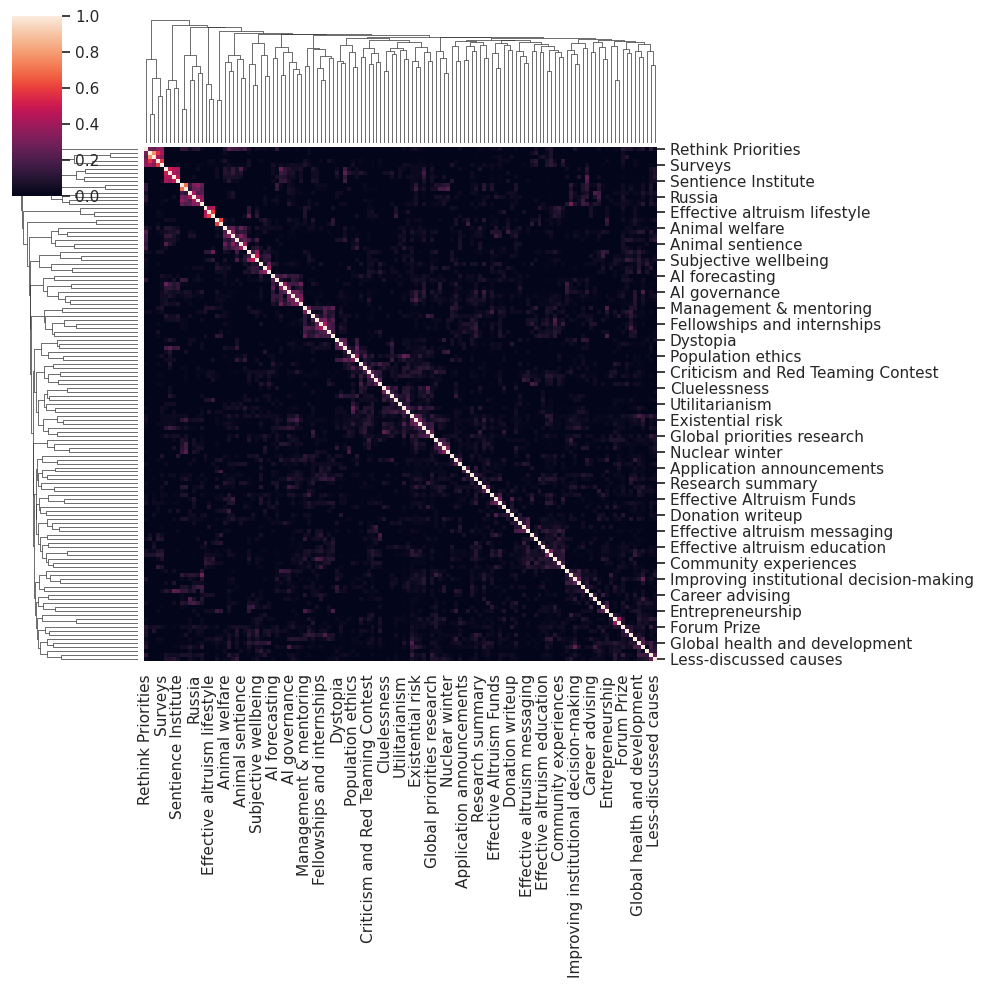

In [89]:
tag_coocs_filt = estimate_cooccurance_probabilities(tags_filt, symmetric=True, normalize=True)
cmap = sns.clustermap(tag_coocs_filt)
linkage, ord = extract_clustering_from_sns(cmap)
cmap;

In [90]:
tag_dists = 1 - tag_coocs_filt
emb_filt = umap.UMAP(metric='precomputed', spread=2, min_dist=0.1).fit_transform(tag_dists)

/home/vpetukhov/local/miniconda3/envs/data_vis/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [91]:
from scipy.cluster.hierarchy import cut_tree

In [92]:
clusts = cut_tree(linkage, height=1.1)[:,0]
pd.value_counts(clusts)

39    4
11    4
9     4
49    3
55    3
     ..
34    1
33    1
31    1
30    1
98    1
Length: 99, dtype: int64

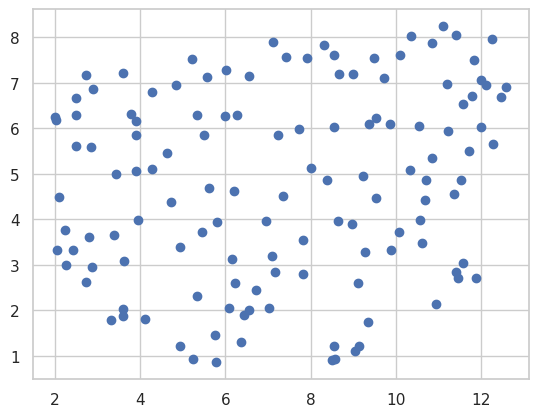

In [93]:
plt.scatter(emb_filt[:,0], emb_filt[:,1])

In [94]:
tag_ids = dict(Series(np.arange(tag_coocs_filt.shape[0]), tag_coocs_filt.index[ord]))

tag_info_json = {
    'tags': [
        {'x': float(x), 'y': float(y), 'tag': tag, 'n_docs': int(n_docs)} 
        for tag, (x, y), n_docs in zip(tag_coocs_filt.index, emb_filt, n_docs_per_tag[tag_coocs_filt.index])
    ],
    'coocs': {
        'freqs': [
            {
                'tag1': t1, 'tag2': t2, 
                'ti1': int(tag_ids[t1]), 'ti2': int(tag_ids[t2]), 
                'cooc': float(f)
            } for (t1,t2),f in tag_coocs_filt.iloc[ord, ord].stack().items()
        ],
        'tags': list(tag_coocs_filt.index[ord])
    }
}

with open('./output/tag_info.json', 'w') as f:
    json.dump(tag_info_json, f)